## *Rodrigo_Mesquita_DR4_TP1*
## *Desenvolvimento de Soluções Big Data com Apache Spark [25E2_4]*

---------

# 🧠 **Parte 1 — Análise Inicial do Grafo**

# 🔗 *Grafo Principal — Multiverso de Rick and Morty*

## 1.Criação do GraphFrame

Construa os DataFrames de vértices e arestas e monte o GraphFrame representando a rede de conexões.

Mostre o conteúdo de gf.vertices e gf.edges.

In [ ]:
%pip install pyspark
%pip install graphframes

In [ ]:
from pyspark.sql import SparkSession

try:
    spark.stop()
except:
    pass
    
spark = SparkSession.builder \
    .appName("app") \
    .master("spark://spark:7077") \
    .config("spark.jars", "gf.jar") \
    .getOrCreate()


In [53]:
from graphframes import GraphFrame

vertices = spark.createDataFrame([
    ("r1", "Rick C-137", "Rick"),
    ("m1", "Morty C-137", "Morty"),
    ("r2", "Rick D-99", "Rick"),
    ("m2", "Morty D-99", "Morty"),
    ("s1", "Summer C-137", "Summer"),
    ("b1", "Birdperson", "Aliado"),
    ("t1", "Tammy", "Inimigo"),
    ("p1", "Phoenixperson", "Inimigo")
], ["id", "nome", "tipo"])

edges = spark.createDataFrame([
    ("r1", "m1", "protege"),
    ("r1", "s1", "protege"),
    ("m1", "s1", "amigo"),
    ("r2", "m2", "protege"),
    ("b1", "r1", "amigo"),
    ("t1", "b1", "traiu"),
    ("p1", "r1", "inimigo"),
    ("r1", "r2", "conhece"),
    ("m1", "m2", "conhece"),
    ("r2", "t1", "suspeita")
], ["src", "dst", "relacao"])

gf = GraphFrame(vertices, edges)

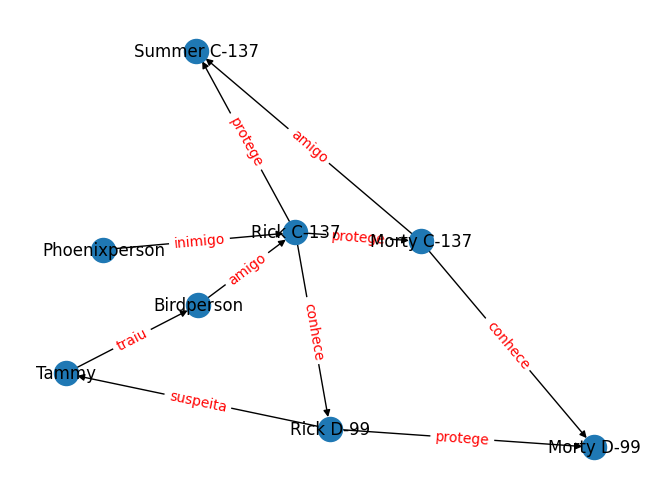

In [55]:
G = nx.DiGraph()
for row in vertices.collect():
    G.add_node(row.id, label=row.nome)

for row in edges.collect():
    G.add_edge(row.src, row.dst, relationship=row.relacao)

pos = nx.spring_layout(G)  
vertices_labels = nx.get_node_attributes(G, 'label')
edge_labels = nx.get_edge_attributes(G, 'relationship')

nx.draw(G, pos, with_labels=True, labels=vertices_labels,  arrows=True)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')

plt.show()

In [20]:
gf.vertices.show()

+---+-------------+-------+
| id|         nome|   tipo|
+---+-------------+-------+
| r1|   Rick C-137|   Rick|
| m1|  Morty C-137|  Morty|
| r2|    Rick D-99|   Rick|
| m2|   Morty D-99|  Morty|
| s1| Summer C-137| Summer|
| b1|   Birdperson| Aliado|
| t1|        Tammy|Inimigo|
| p1|Phoenixperson|Inimigo|
+---+-------------+-------+



In [54]:
gf.edges.show()

+---+---+--------+
|src|dst| relacao|
+---+---+--------+
| r1| m1| protege|
| r1| s1| protege|
| m1| s1|   amigo|
| r2| m2| protege|
| b1| r1|   amigo|
| t1| b1|   traiu|
| p1| r1| inimigo|
| r1| r2| conhece|
| m1| m2| conhece|
| r2| t1|suspeita|
+---+---+--------+



In [23]:
import networkx as nx
import matplotlib.pyplot as plt

## 2.Cálculo de Grau dos Personagens

Utilize os métodos inDegrees e outDegrees para calcular:
* Grau de entrada (inDegree);
* Grau de saída (outDegree).
* Identifique o personagem com maior grau de saída.

In [21]:
gf.inDegrees.show()

+---+--------+
| id|inDegree|
+---+--------+
| s1|       2|
| m2|       2|
| r1|       2|
| r2|       1|
| t1|       1|
| m1|       1|
| b1|       1|
+---+--------+



In [22]:
gf.outDegrees.show()

+---+---------+
| id|outDegree|
+---+---------+
| r1|        3|
| t1|        1|
| b1|        1|
| r2|        2|
| m1|        2|
| p1|        1|
+---+---------+



In [33]:
print("Linha com maior grau de saída")
gf.outDegrees.orderBy("outDegree", ascending=False).first()

Linha com maior grau de saída


Row(id='r1', outDegree=3)

## 3.Busca de Padrões Específicos

Utilize gf.find para localizar padrões onde:
* Um Rick protege um Morty que é amigo de uma Summer.
* Mostre o código e o resultado.

In [56]:
gf.find("(a)-[e1]->(b); (b) - [e2] -> (c)") \
    .filter("a.tipo = 'Rick' AND e1.relacao = 'protege' AND b.tipo = 'Morty' AND e2.relacao = 'amigo' AND c.tipo = 'Summer'") \
    .show()


+--------------------+-----------------+--------------------+---------------+--------------------+
|                   a|               e1|                   b|             e2|                   c|
+--------------------+-----------------+--------------------+---------------+--------------------+
|{r1, Rick C-137, ...|{r1, m1, protege}|{m1, Morty C-137,...|{m1, s1, amigo}|{s1, Summer C-137...|
+--------------------+-----------------+--------------------+---------------+--------------------+



# 4.Determinação dos Personagens Mais Influentes (PageRank)

Execute o algoritmo PageRank com resetProbability=0.15 e mostre:

* Os 3 personagens mais influentes da rede.

In [5]:
pr = gf.pageRank(resetProbability=0.15, maxIter=100)
pr.vertices.select("id","pagerank").orderBy("pagerank",ascending=False).head(3)

[Row(id='r1', pagerank=1.6459888280021941),
 Row(id='s1', pagerank=1.238756026558751),
 Row(id='m2', pagerank=1.1418460770721424)]

## 5. Caminho Limitado entre Rick C-137 e Phoenixperson (BFS)

Use bfs para encontrar um caminho de no máximo 3 passos entre Rick C-137 e Phoenixperson.

In [57]:
#NÃO EXISTE CAMINHO DE RICK C-137 PARA PHOENIXPERSON, APENAS HÁ ROTA NO SENTIDO INVERSO.
gf.bfs (
    fromExpr="nome = 'Rick C-137'",
    toExpr="nome = 'Phoenixperson'",
    maxPathLength=3
).show()

+---+----+----+
| id|nome|tipo|
+---+----+----+
+---+----+----+



In [58]:
#MOSTRANDO A ROTA NO SENTIDO INVERSO, DE PHOENIX PARA RICK.
gf.bfs (
    fromExpr="nome = 'Phoenixperson'",
    toExpr="nome = 'Rick C-137'",
    maxPathLength=3
).show()

+--------------------+-----------------+--------------------+
|                from|               e0|                  to|
+--------------------+-----------------+--------------------+
|{p1, Phoenixperso...|{p1, r1, inimigo}|{r1, Rick C-137, ...|
+--------------------+-----------------+--------------------+



# 6. Análise de Componentes Conectados

Utilize o algoritmo connectedComponents para identificar:
* Quantos componentes existem no grafo;
* Quais personagens pertencem a cada componente.

In [4]:
from pyspark.sql import SparkSession
from graphframes import GraphFrame


try:
    spark.stop()
except:
    pass
    
spark = SparkSession.builder \
    .appName("app") \
    .master("local[*]") \
    .config('job.local.dir', 'file:/work/spark-checkpoints') \
    .config("spark.jars", "gf.jar") \
    .getOrCreate()


vertices = spark.createDataFrame([
    ("r1", "Rick C-137", "Rick"),
    ("m1", "Morty C-137", "Morty"),
    ("r2", "Rick D-99", "Rick"),
    ("m2", "Morty D-99", "Morty"),
    ("s1", "Summer C-137", "Summer"),
    ("b1", "Birdperson", "Aliado"),
    ("t1", "Tammy", "Inimigo"),
    ("p1", "Phoenixperson", "Inimigo")
], ["id", "nome", "tipo"])

edges = spark.createDataFrame([
    ("r1", "m1", "protege"),
    ("r1", "s1", "protege"),
    ("m1", "s1", "amigo"),
    ("r2", "m2", "protege"),
    ("b1", "r1", "amigo"),
    ("t1", "b1", "traiu"),
    ("p1", "r1", "inimigo"),
    ("r1", "r2", "conhece"),
    ("m1", "m2", "conhece"),
    ("r2", "t1", "suspeita")
], ["src", "dst", "relacao"])

gf = GraphFrame(vertices, edges)

In [5]:
spark.sparkContext.setCheckpointDir("/work/spark-checkpoints")

ConComponents = gf.connectedComponents()
num_components = ConComponents.select("component").distinct().count()
print("Número de Componentes Conectados: ", num_components)

/usr/local/lib/python3.12/site-packages/pyspark/sql/dataframe.py:147: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


Número de Componentes Conectados:  1


# 7.Detecção de Triângulos de Relações

Usando motif finding, encontre todos os triângulos (3 personagens conectados entre si) no grafo.

In [17]:
triangulos = gf.find("(a)-[]->(b); (a)-[]->(c); (b)-[]->(c)").show()

+--------------------+--------------------+--------------------+
|                   a|                   b|                   c|
+--------------------+--------------------+--------------------+
|{r1, Rick C-137, ...|{m1, Morty C-137,...|{s1, Summer C-137...|
+--------------------+--------------------+--------------------+



## 8. Explique:

* Como o aumento de novos Mortys impactaria a estrutura da rede
* O efeito sobre graus, componentes e rankings

* Efeito sobre graus: Poderá alterar o grau médio, dependendo de SE e COMO irão se conectar a outros vertices.
* Efeito sobre componentes: Poderá alterar o número de componentes, dependendo se irão ser conectados ao componente existente ou não.
* Efeito sobre ranking: Se considerarmos apenas o "tipo" = Morty, caso seja feita qualquer conexão a outros vertices, irá aumentar o ranking dele. Porém, se os novos "Mortys" possuírem "nomes" distintos, o efeito sobre o ranking depende de a quem irão se conectar. 

# **🚀 Parte 2 — Desafios Avançados no Multiverso**

# 🔗 *Grafo 2 — Cidadela dos Ricks*

## 9.Vulnerabilidade dos Ricks (Shortest Paths)

Construa o GraphFrame com os dados acima.

Calcule usando shortestPaths:

* A menor distância de cada Rick até o Presidente Morty;
* Identifique qual Rick é o mais vulnerável ao controle.

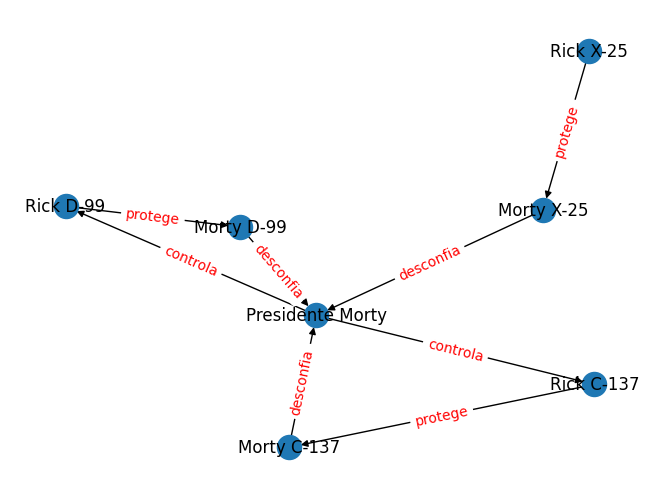

In [72]:
G = nx.DiGraph()
for row in vertices.collect():
    G.add_node(row.id, label=row.nome)

for row in edges.collect():
    G.add_edge(row.src, row.dst, relationship=row.relacao)

pos = nx.spring_layout(G)  
vertices_labels = nx.get_node_attributes(G, 'label')
edge_labels = nx.get_edge_attributes(G, 'relationship')

nx.draw(G, pos, with_labels=True, labels=vertices_labels,  arrows=True)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')

plt.show()

In [60]:
vertices = spark.createDataFrame([
    ("r1", "Rick C-137"),
    ("r2", "Rick D-99"),
    ("r3", "Rick X-25"),
    ("m1", "Morty C-137"),
    ("m2", "Morty D-99"),
    ("m3", "Morty X-25"),
    ("p1", "Presidente Morty")
], ["id", "nome"])

edges = spark.createDataFrame([
    ("r1", "m1", "protege"),
    ("r2", "m2", "protege"),
    ("r3", "m3", "protege"),
    ("m1", "p1", "desconfia"),
    ("m2", "p1", "desconfia"),
    ("m3", "p1", "desconfia"),
    ("p1", "r1", "controla"),
    ("p1", "r2", "controla")
], ["src", "dst", "relacao"])

gf2 = GraphFrame(vertices, edges)

#### Todos os Ricks estão a 2 passos até o Presidente Morty

In [75]:
#Calcula a menor distancia de cada vértice até o vértice p1
shortest = gf2.shortestPaths(landmarks=['p1'])

#filtra pra manter somente os vertices dos Ricks
result = shortest.filter(shortest.id.isin(['r1', 'r2', 'r3']))
result.select("id", "distances").show(truncate=False)

+---+---------+
|id |distances|
+---+---------+
|r1 |{p1 -> 2}|
|r2 |{p1 -> 2}|
|r3 |{p1 -> 2}|
+---+---------+



#### Tanto o Rick C-137 quanto o Rick D-99 estão a apenas 1 passo do Presidente Morty, sendo controlados

In [87]:
shortest = gf2.shortestPaths(landmarks=['r1', 'r2', 'r3'])
result = shortest.filter(shortest.id.isin(['p1']))
result.show()

+---+----------------+------------------+
| id|            nome|         distances|
+---+----------------+------------------+
| p1|Presidente Morty|{r2 -> 1, r1 -> 1}|
+---+----------------+------------------+



# 🔗 *Grafo 3 — Dimensão Colapsada*

## 10.Ciclos de Controle na Dimensão Colapsada (SCC)

Utilize o algoritmo stronglyConnectedComponents para:

* Identificar os componentes fortemente conectados;
* Explicar o significado do ciclo entre Rick C-137, Evil Rick e Evil Morty.

In [98]:
vertices = spark.createDataFrame([
    ("r1", "Rick C-137"),
    ("e1", "Evil Rick"),
    ("m1", "Morty C-137"),
    ("m4", "Evil Morty"),
    ("t1", "Tammy")
], ["id", "nome"])

edges = spark.createDataFrame([
    ("r1", "e1", "suspeita"),
    ("e1", "m4", "controla"),
    ("m4", "r1", "manipula"),
    ("m1", "m4", "inveja"),
    ("t1", "e1", "aliado"),
    ("t1", "m4", "espionagem")
], ["src", "dst", "relacao"])

gf3 = GraphFrame(vertices, edges)

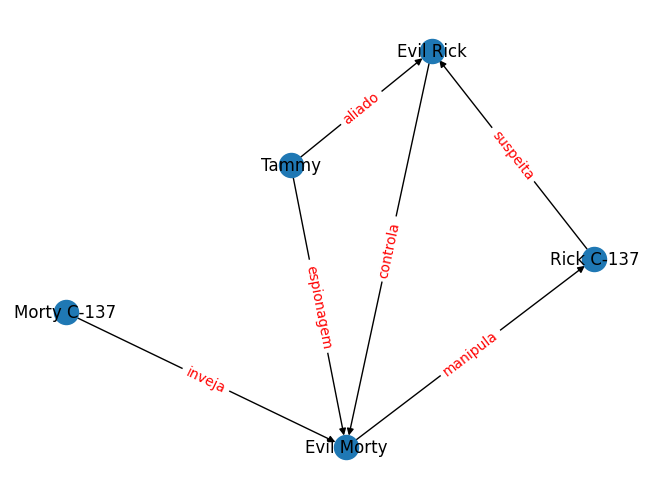

In [101]:
G = nx.DiGraph()
for row in vertices.collect():
    G.add_node(row.id, label=row.nome)

for row in edges.collect():
    G.add_edge(row.src, row.dst, relationship=row.relacao)

pos = nx.spring_layout(G)  
vertices_labels = nx.get_node_attributes(G, 'label')
edge_labels = nx.get_edge_attributes(G, 'relationship')

nx.draw(G, pos, with_labels=True, labels=vertices_labels,  arrows=True)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')

plt.show()

#### Rick C-137, Evil Rick e Evil Morty são componentes fortemente conectados
#### Rick C-137 suspeita de Evil Rick, que controla Evil Morty, que manipula Rick-137, fechando o ciclo

In [100]:
result = gf3.stronglyConnectedComponents(maxIter=50)
result.select("nome","component").orderBy("component").show()

+-----------+-------------+
|       nome|    component|
+-----------+-------------+
| Rick C-137| 403726925824|
|  Evil Rick| 403726925824|
| Evil Morty| 403726925824|
|      Tammy| 807453851648|
|Morty C-137|1305670057984|
+-----------+-------------+

